In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImage,
    LoadImaged,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    Spacingd,
    SpatialPadd,
    CastToTyped
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/sven/miniconda3/envs/mlmi/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:


In [2]:
import pandas as pd
import os
from enum import Enum
from monai.transforms import Transform

class Modality(Enum):
    MR_T1 = 1
    MR_T2 = 2
    MR_T2_STAR = 3
    MR_FLAIR = 4
    MR_TOF_MRA = 5

def create_oasis_3_dataset(csv_path: str, dataset_root: str, modality: Modality, transform: Transform, cache_rate: float):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    column_name = ""
    if modality == Modality.MR_T1:
        column_name = "MR T1w"
    elif modality == Modality.MR_T2:
        column_name = "MR T2w"
    elif modality == Modality.MR_T2_STAR:
        column_name = "MR T2*"
    elif modality == Modality.MR_FLAIR:
        column_name = "MR FLAIR"
    elif modality == Modality.MR_TOF_MRA:
        column_name = "MR TOF-MRA"
    else:
        assert(False)

    train_data = []
    for index, row in train_df.iterrows():
        rel_path = row[column_name]
        if not rel_path:
            continue
        image_path = os.path.join(dataset_root, rel_path)
        train_data.append({"image": image_path, "label" : row["label"]})

    print(len(train_data))
    return CacheDataset(data=train_data, transform=transform, cache_rate=cache_rate, num_workers=5, copy_cache=False)

In [3]:
dataset_root = "/mnt/f/OASIS-3-MR-Sessions-2D/"
resolution = 256
cache_rate = 0.5 # might need to change this based on the amount of memory available
batch_size = 8

foreground_crop_threshold = 0.1
train_table_path = "csv/oasis/oasis_3_multimodal_train.csv"
transform = Compose([
    LoadImaged("image", image_only=True),
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),  
    EnsureTyped("image"),
    CastToTyped("label", dtype=np.float64),
    ScaleIntensityd("image"),
    CropForegroundd("image", source_key="image", select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    Resized(keys=["image"], spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=["image"], spatial_size=(resolution, resolution)),
    ]
)
train_ds = create_oasis_3_dataset(csv_path=train_table_path, dataset_root=dataset_root, modality=Modality.MR_T1, transform=transform, cache_rate=cache_rate)
# disable multi-workers because `ThreadDataLoader` works with multi-threads
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=batch_size, shuffle=True)

val_table_path = "csv/oasis/oasis_3_multimodal_val.csv"
val_ds = create_oasis_3_dataset(csv_path=val_table_path, dataset_root=dataset_root, modality=Modality.MR_T1, transform=transform, cache_rate=cache_rate)
# disable multi-workers because `ThreadDataLoader` works with multi-threads
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=batch_size, shuffle=True)

2547


Loading dataset: 100%|██████████| 1273/1273 [00:38<00:00, 33.13it/s]


284


Loading dataset: 100%|██████████| 142/142 [00:04<00:00, 33.37it/s]


torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])
torch.Size([1, 256, 256])
torch.Size([8, 1])


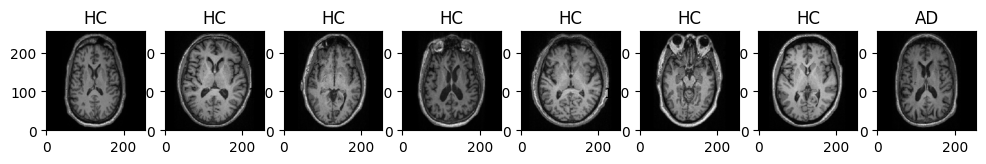

In [5]:
dataiter = iter(train_loader)
batch_sample = next(dataiter)
images = batch_sample["image"]
labels = batch_sample["label"]

classes = ["HC", "AD"]

plt.figure(figsize=(12, 6))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data[0]
    print(sample_data.shape)
    print(labels.shape)
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label[0])]}")  # Display the label as the title
    i += 1
plt.show()

### Define network and optimizer

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=1).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

### Training

In [7]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

y_pred_trans = Compose([Activations(sigmoid=True)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [i for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(result)
            acc_value = torch.eq(y_pred_act > 0.5, y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            del y_pred_act, y_onehot
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                #torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

# TODO: fix metrics

----------
epoch 1/4
1/318, train_loss: 0.7431
2/318, train_loss: 0.7493
3/318, train_loss: 0.7671
4/318, train_loss: 0.7429
5/318, train_loss: 0.7528
6/318, train_loss: 0.7589
7/318, train_loss: 0.7220
8/318, train_loss: 0.6788
9/318, train_loss: 0.7519
10/318, train_loss: 0.7465
11/318, train_loss: 0.7126
12/318, train_loss: 0.7446
13/318, train_loss: 0.7288
14/318, train_loss: 0.7406
15/318, train_loss: 0.7137
16/318, train_loss: 0.7148
17/318, train_loss: 0.7268
18/318, train_loss: 0.6944
19/318, train_loss: 0.7183
20/318, train_loss: 0.7243
21/318, train_loss: 0.7240
22/318, train_loss: 0.7088
23/318, train_loss: 0.6789
24/318, train_loss: 0.7011
25/318, train_loss: 0.7135
26/318, train_loss: 0.7162
27/318, train_loss: 0.6989
28/318, train_loss: 0.7060
29/318, train_loss: 0.7034
30/318, train_loss: 0.6932
31/318, train_loss: 0.6877
32/318, train_loss: 0.6896
33/318, train_loss: 0.6832
34/318, train_loss: 0.6890
35/318, train_loss: 0.6879
36/318, train_loss: 0.6892
37/318, train_lo

TypeError: '>' not supported between instances of 'list' and 'float'